In [19]:
import json
from pprint import pprint
import pandas as pd

from nltk.tokenize import TweetTokenizer

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from pathlib import Path

# Constructing the basic dataset

In [24]:
data_folder = Path('../data/twint')
tweet_file = data_folder / './data/twint/2019_april_may_#uber_EN.txt'

In [25]:
f = open(tweets_file, 'r')
lines = [l for l in f]
f.close()
tweets = [json.loads(l) for l in lines]
unique_usernames = {t['username'] for t in tweets}

In [26]:
print('Number of tweets: %s' % len(tweets))
print('\n')
pprint(tweets[0])
print('\n')
print('Number of unique users: %s' % len(unique_usernames))
print('\n')
pprint(list(unique_usernames)[:10])

Number of tweets: 38493


{'cashtags': [],
 'conversation_id': '1134217832886149120',
 'created_at': 1559253578000,
 'date': '2019-05-30',
 'geo': '',
 'hashtags': ['#uber', '#ipo'],
 'id': 1134217832886149120,
 'likes_count': 11,
 'link': 'https://twitter.com/Rokk3rFuel/status/1134217832886149120',
 'mentions': ['uber', 'cnbcclosingbell'],
 'name': 'Rokk3r Fuel ExO',
 'near': '',
 'photos': [],
 'place': '',
 'quote_url': '',
 'replies_count': 0,
 'reply_to': [{'user_id': '803710812649033728', 'username': 'Rokk3rFuel'},
              {'user_id': '19103481', 'username': 'Uber'},
              {'user_id': '21778391', 'username': 'CNBCClosingBell'}],
 'retweet': False,
 'retweet_date': '',
 'retweet_id': '',
 'retweets_count': 0,
 'source': '',
 'time': '23:59:38',
 'timezone': '+0200',
 'trans_dest': '',
 'trans_src': '',
 'translate': '',
 'tweet': '"The question prospective investors have to ask themselves about '
          '#Uber is not how much the stock has dipped since the #IPO, b

# Text preparation

## Concatening all the tweets (= document) for each user

In [ ]:
users_to_tweets_list = {u:[] for u in list(unique_usernames)}

for t in tweets:
    username = t['username']
    users_to_tweets_list[username].append(t['tweet'].replace('\n', ''))

users_to_documents = {u:'' for u in list(unique_usernames)}
for u in unique_usernames:
    tweets_list = users_to_tweets_list[u]
    user_document = ''.join(tweets_list)
    users_to_documents[u] = user_document

## Tokenizing

In [ ]:
tokenizer = TweetTokenizer()

In [ ]:
users_to_documents = {u:tokenizer.tokenize(doc) for (u, doc) in users_to_documents.items()}

In [ ]:
list(users_to_documents.items())[0]

## Remove non-alpha characters and lowercase

In [ ]:
list(users_to_documents.items())[0]

In [ ]:
for u, d in users_to_documents.items():
    filtered = [token.lower() for token in d if token.isalpha()]
    users_to_documents[u] = filtered

In [ ]:
list(users_to_documents.items())[0]

##  Filter out stopwords

In [ ]:
stop_words = stopwords.words('english')

for u, d in users_to_documents.items():
    filtered = [token.lower() for token in d if token not in stop_words]
    users_to_documents[u] = filtered

## Stemming

In [ ]:
from nltk.stem import PorterStemmer

In [ ]:
stop_words = stopwords.words('english')
stemmer = PorterStemmer()

for u, d in users_to_documents.items():
    filtered = [stemmer.stem(token) for token in d]
    users_to_documents[u] = filtered

In [ ]:
list(users_to_documents.items())[0]

## Filter out single letters

In [330]:
for u, d in users_to_documents.items():
    filtered = [stemmer.stem(token) for token in d if len(token) > 1]
    users_to_documents[u] = filtered

## Filter out any users that now have less than 100 words

In [355]:
c = dict(users_to_documents)
for u, doc in users_to_documents.items():
    if len(doc) < 100:
        del c[u]
    
users_to_documents_filtered = c

In [356]:
len(users_to_documents_filtered)

291

# Constructing the Term/Document Matrix

In [357]:
from sklearn.feature_extraction.text import CountVectorizer

In [358]:
docs = users_to_documents_filtered.values()

In [366]:
def do_nothing(tokens):
    return tokens

vectorizer = CountVectorizer(lowercase=False, tokenizer=do_nothing)

X = vectorizer.fit_transform(docs)

In [367]:
docs_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [368]:
docs_df

,aa,aaaaand,aaatrad,aapl,aaront,aayat,ab,abandon,abc,abdi,...,zoo,zoom,zoomub,zuck,zyng,刘玉兰,데이식스,마크,박재범,시우민
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
288,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
289,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Performing a PCA

In [369]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

Text(0.5, 0.92, 'PCA')

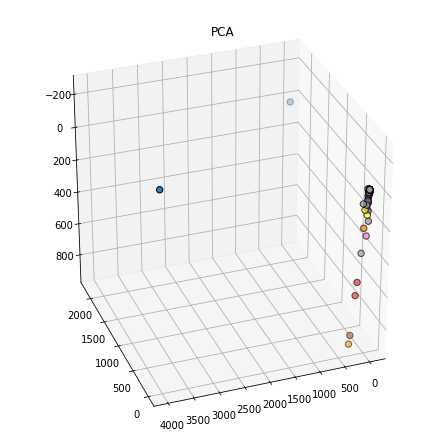

In [370]:
pca = PCA(n_components=10)
X_reduced = pca.fit_transform(docs_df)
fig = plt.figure(1, figsize=(6, 6))
ax = Axes3D(fig, elev=-150, azim=110)
y = range(0, len(X_reduced))
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("PCA")

In [405]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
features_ = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

importances = [sorted(np.abs(j), reverse=True)[:5] for i in range(n_pcs) for j in pca.components_[i]]

initial_feature_names = list(docs_df.columns.values)
# get the names
most_important_names = [initial_feature_names[importances[j]] for i in range(n_pcs) for j in range(0, len(importances))]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

df

TypeError: 'numpy.float64' object is not iterable